In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [2]:
#from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, execute
#from qiskit_ibm_runtime import QiskitRuntimeService
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

N = 4
sigma = 3
mu = 7

QRn = N
CRn = N
qreg_q = QuantumRegister(QRn, 'q')
creg_c = ClassicalRegister(CRn, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

def norm_(sigma_, mu_, N):
    """
    Normalization factor for the state. Defined in Eq (7) of paper.
    Inputs:-
    sigma_: standard deviation
    mu_: mean
    N: cutoff the for the infinite sum, i.e. sum_{i=-N}^{i=N} (...)
    """
    return np.sum(np.exp((-(np.arange(-N, N+1, 1) - mu_)**2)/float(sigma_**2)))

def angle_(sigma_, mu_, N=10**3):
    """
    The angle $\alpha$ defined in Eq (12)
    Inputs:-
    sigma_: standard deviation
    mu_: mean
    N: cutoff for the infinite sum in the norm_(..)
    """
    return np.arccos(np.sqrt(norm_(sigma_/2., mu_/2., N)/norm_(sigma_, mu_, N)))

def qubit_strings(n):
    """
    Return a list of n-bit strings in increasing lexicographic order
    Inputs:-
    n: recursion level
    """
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings

def mean_qubit_combo(qub, mu):
    """
    Given an n-bit string, return the corresponding mean for the rotation angle
    at recursion level n
    Inputs:-
    qub: n-bit string
    mu: mean (original)
    """
    mu_out = mu
    for bit in qub:
        mu_out = (mu_out/2.) - ((1/2.)*int(bit))
    return mu_out

def level_means(mu, n):
    """
    At recursion level n, return a list of all the means used for the various rotation angles
    Inputs:-
    mu: mean (original)
    n: recursion level
    """
    list_mu_out = []
    qb_strings = qubit_strings(n)
    for qb in qb_strings:
        mu_out = mean_qubit_combo(qb, mu)
        list_mu_out.append(mu_out)
    return list_mu_out

def level_angles(sigma, mu, n):
    """
    At recursion level n, return a list of all the rotation angles
    Inputs:-
    sigma: standard deviation (original)
    mu: mean (original)
    n: recursion level
    """
    sigma_out = sigma/(2.**n)
    list_mu = level_means(mu, n)
    angles_out = []
    for mu_ in list_mu:
        angles_out.append(angle_(sigma_out, mu_))
    return angles_out

def rotation_block(alpha):
    """
    Given a rotation angle $\alpha$, return a 2x2 rotation block (numpy array)
    Inputs:-
    alpha: rotation angle
    """
    return np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

def level_gate(sigma, mu, n):
    """
    Return (n+1)-qubit controlled operation as a 2^(n+1) x 2^(n+1) matrix,
    with 2^n rotation blocks along the diagonal
    Inputs:-
    sigma: standard deviation (original)
    mu: mean (original)
    n: recursion level
    """
    list_row_block = []
    list_level_angles = level_angles(sigma, mu, n)
    for nn, angle in enumerate(list_level_angles):
        rot_block = rotation_block(angle)
        row_block = np.hstack((np.zeros((2, 2*nn)), rot_block, np.zeros((2, 2*(2**(n) - nn - 1)))))
        list_row_block.append(row_block)
    level_n_gate = np.vstack(tuple(list_row_block))
    return level_n_gate

def list_all_gates(sigma, mu, N):
    """
    Given sigma, mu (standard dev, mean) and the number of qubits N,
    return a list of all gates used for the controlled operations required
    to produce a Gaussian wavefunction
    Inputs:-
    sigma: standard deviation (original)
    mu: mean (original)
    N: number of qubits to be used
    """
    list_gates = []
    for n in range(N):
        list_gates.append(level_gate(sigma, mu, n))

    return list_gates

from qiskit.quantum_info.operators import Operator
def defn_all_gates(sigma, mu, N):
    """
    Define all gates specified by N qubits, for (standard deviation, mean) given by (sigma, mu),
    into the program input which is specified by prog
    Inputs:-
    sigma: standard deviation (original)
    mu: mean (original)
    N: number of qubits to be used
    prog: Program object
    """
    list_gates_ = list_all_gates(sigma, mu, N)

    start = 0
    
    for i, gate in enumerate(list_gates_):
        temp = [n for n in range(i+1)]
        end = i + 1
        
        for k in range(start, (end + start) // 2, 1):
            circuit.swap(k, end + start - k - 1)
        
        circuit.append(Operator(gate), temp)
        
        for k in range(start, (end + start) // 2, 1):
            circuit.swap(k, end + start - k - 1)
        
        circuit.barrier(np.arange(0, N))
        

defn_all_gates(sigma, mu, N)

for i in range(0, N, 1):
   circuit.measure(qreg_q[i], creg_c[i])

#editor = CircuitComposer(circuit=circuit)
#editor
#circuit.draw()


Total count are: {'0100': 1404, '0111': 3751, '1010': 1397, '0101': 2428, '0110': 3419, '1000': 3230, '1101': 72, '1001': 2440, '0011': 659, '1011': 652, '1100': 230, '0010': 220, '0000': 12, '0001': 68, '1110': 8, '1111': 10}


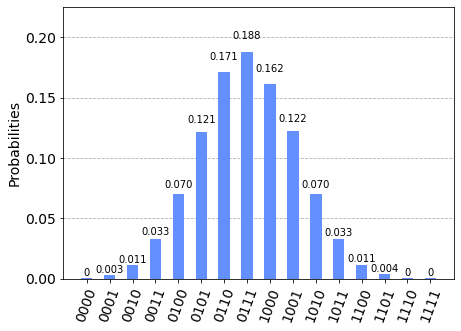

In [3]:
from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(circuit, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ, shots=20000)
result = job.result()

# Returns counts
counts = result.get_counts(circ)
print("\nTotal count are:",counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)


Total count are: {'0110': 3289, '0111': 3802, '0100': 1415, '1000': 3447, '0101': 2351, '0001': 69, '1001': 2436, '1010': 1411, '0011': 633, '1011': 570, '0010': 221, '1100': 248, '1101': 70, '0000': 18, '1111': 5, '1110': 15}


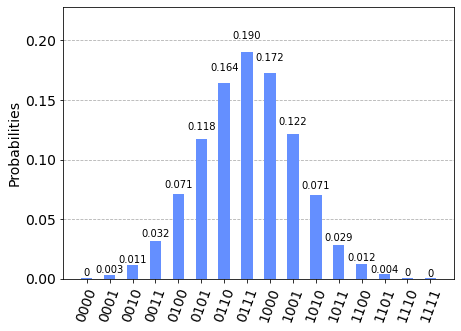

In [4]:
#ibmq_noise_model = provider.get_backend('ibmq_quito')

#simulator = QasmSimulator.from_backend(ibmq_noise_model)

simulator = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=20000)

#QC
#job = execute(circuit, backend=ibmq_noise_model, shots=8192)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count are:",counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)